In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re

import pickle
import gensim 
from gensim import corpora, models, similarities
from gensim.models import Doc2Vec, Phrases
from gensim.models.phrases import Phraser
import multiprocessing

%matplotlib inline
assert gensim.models.doc2vec.FAST_VERSION > -1
cores = multiprocessing.cpu_count()

In [47]:
df = pd.read_csv('items_avidhya.csv')

In [48]:
df.shape

(334, 7)

In [49]:
df.head()

,description,years_exp,country,salary_range,job_category,job_title,required_skills
0,"● Selecting features, building and optimizing ...",4.0,"Bengaluru,Thiruvananthapuram",800k to 3000k,Data_Analytics,Data Scientist - Trivandrum / Bangalore ( 4 - ...,"Boosting,D3.Js,Deep Learning,Ggplot2,Hbase,Hiv..."
1,Requirements:-•Expertise in Java-•Expertise an...,3.0,"Calcutta,Pune",500k to 800k,Data_Analytics,AWS/ Cloud Engineer - Pune/Kolkata (3 to 7 yea...,"Aws,Data Mining,Java,Machine Learning,Nlp,Nosq..."
2,Does Not Matter-Under Graduate- 500k to 850k-\...,3.0,Pune,500k to 850k,Data_Analytics,Business Analyst- Pune (3-4 Years of Experience),"Excel,Qlikview,R,Sql,Statistics,Tableau,Vba"
3,•Research the evolving datasets and advanced a...,2.0,"Gurugram,Pune",1500k to 2500k,Data_Analytics,Data Science Consultant – Real World Evidence ...,"Hadoop,Java,Machine Learning,Python,R,Real Wor..."
4,•Interpret calling output for data quality-•Ru...,1.0,Ahmedabad,300k to 500k,Data_Analytics,Analyst- Ahmedabad (1-2 years of experience),"Analytics,Sql"


In [50]:
sr_str = pd.DataFrame([s.split('to') for s in df.salary_range], columns=['lower_sgd','higher_sgd'])

In [51]:
def from_k(s):
    return(s.replace('k','000').lstrip().rstrip())
for a in sr_str.columns:
    sr_str[a] = sr_str[a].apply(from_k)
df = pd.concat([df,sr_str], axis=1)

In [52]:
for a in sr_str.columns:
    df[a] = df[a].apply(float)
    df[a] = (df[a] * 0.021)/12.0

In [53]:
df.drop(['salary_range'],axis=1, inplace=True)

In [54]:
df.head(5)

,description,years_exp,country,job_category,job_title,required_skills,lower_sgd,higher_sgd
0,"● Selecting features, building and optimizing ...",4.0,"Bengaluru,Thiruvananthapuram",Data_Analytics,Data Scientist - Trivandrum / Bangalore ( 4 - ...,"Boosting,D3.Js,Deep Learning,Ggplot2,Hbase,Hiv...",1400.0,5250.0
1,Requirements:-•Expertise in Java-•Expertise an...,3.0,"Calcutta,Pune",Data_Analytics,AWS/ Cloud Engineer - Pune/Kolkata (3 to 7 yea...,"Aws,Data Mining,Java,Machine Learning,Nlp,Nosq...",875.0,1400.0
2,Does Not Matter-Under Graduate- 500k to 850k-\...,3.0,Pune,Data_Analytics,Business Analyst- Pune (3-4 Years of Experience),"Excel,Qlikview,R,Sql,Statistics,Tableau,Vba",875.0,1487.5
3,•Research the evolving datasets and advanced a...,2.0,"Gurugram,Pune",Data_Analytics,Data Science Consultant – Real World Evidence ...,"Hadoop,Java,Machine Learning,Python,R,Real Wor...",2625.0,4375.0
4,•Interpret calling output for data quality-•Ru...,1.0,Ahmedabad,Data_Analytics,Analyst- Ahmedabad (1-2 years of experience),"Analytics,Sql",525.0,875.0


In [55]:
new_titles = []
for a in df.job_title:
#     x = a.decode('utf-8')
    x = re.sub(u'\u2013','-',a)
    x = re.sub('\xe2\x80\x93', '-',x)
    x = x.split('-')[0].lstrip().rstrip()
    new_titles.append(x)

In [56]:
df.job_title = new_titles

In [57]:
df.head(5)

,description,years_exp,country,job_category,job_title,required_skills,lower_sgd,higher_sgd
0,"● Selecting features, building and optimizing ...",4.0,"Bengaluru,Thiruvananthapuram",Data_Analytics,Data Scientist,"Boosting,D3.Js,Deep Learning,Ggplot2,Hbase,Hiv...",1400.0,5250.0
1,Requirements:-•Expertise in Java-•Expertise an...,3.0,"Calcutta,Pune",Data_Analytics,AWS/ Cloud Engineer,"Aws,Data Mining,Java,Machine Learning,Nlp,Nosq...",875.0,1400.0
2,Does Not Matter-Under Graduate- 500k to 850k-\...,3.0,Pune,Data_Analytics,Business Analyst,"Excel,Qlikview,R,Sql,Statistics,Tableau,Vba",875.0,1487.5
3,•Research the evolving datasets and advanced a...,2.0,"Gurugram,Pune",Data_Analytics,Data Science Consultant,"Hadoop,Java,Machine Learning,Python,R,Real Wor...",2625.0,4375.0
4,•Interpret calling output for data quality-•Ru...,1.0,Ahmedabad,Data_Analytics,Analyst,"Analytics,Sql",525.0,875.0


In [58]:
new_descrip = []
for a in df.description:
    x = ''.join([i if ord(i) < 128 else ' ' for i in a])
    new_descrip.append(x)
df.description = new_descrip


In [59]:
req_val = df.loc[df.description=='!!!',['required_skills']]  
df.loc[df.description=='!!!',['description']] = req_val

In [60]:
all_jobs = pickle.load(open('all_jobs','rb'))

In [61]:
drop_cols = ['date_created','equity','job_type','last_updated',
             'currency','lower','higher','rate','index','vacancies','company',
            'country']
all_jobs.drop(drop_cols,axis=1, inplace=True)

In [62]:
all_jobs = all_jobs[all_jobs.salary_range.isnull()==False]

In [63]:
all_jobs.rename(columns={'years_of_experience_required':'years_exp'}, inplace=True)

In [64]:
all_jobs.head(3)

,job_title,description,required_skills,job_category,salary_range,years_exp,lower_sgd,higher_sgd
0,Data Scientist,"Tech in Asia (YC W15) is a media, events, and ...",Amazon Web Services (AWS) Data Visualization S...,Data & Analytics,"SGD 4,500 - 6,000",1 – 4 years,4500,6000.0
1,Data Scientist,Description\n\nThe focus of our data science t...,What is it like working at F Corporation?Worki...,Data & Analytics,"IDR 5,000,000 - 9,000,000",1 – 4 years,490,882.0
2,Data Scientist,"Job Description:\nTransform large, complex dat...",Python Hadoop SQL,Data & Analytics,"IDR 9,000,000 - 12,000,000",1 – 4 years,882,1176.0


In [65]:
# all_jobs = all_jobs[all_jobs.years_exp.isnull() == False]

In [66]:
# Logical XOR: bool(a) != bool(b)
# all_jobs.isnull().sum()
salary_index = (all_jobs.lower_sgd.isnull()==True) | (all_jobs.higher_sgd.isnull()==True)
sal_val = all_jobs[salary_index].salary_range.apply(float)

In [67]:
# for ind,row in all_jobs[salary_index].iterrows():
#     row['lower_sgd'] = sal_val[ind]
#     row['higher_sgd'] = sal_val[ind]
#     print(sal_val[ind])
all_jobs

,job_title,description,required_skills,job_category,salary_range,years_exp,lower_sgd,higher_sgd
0,Data Scientist,"Tech in Asia (YC W15) is a media, events, and ...",Amazon Web Services (AWS) Data Visualization S...,Data & Analytics,"SGD 4,500 - 6,000",1 – 4 years,4500,6000.0
1,Data Scientist,Description\n\nThe focus of our data science t...,What is it like working at F Corporation?Worki...,Data & Analytics,"IDR 5,000,000 - 9,000,000",1 – 4 years,490,882.0
2,Data Scientist,"Job Description:\nTransform large, complex dat...",Python Hadoop SQL,Data & Analytics,"IDR 9,000,000 - 12,000,000",1 – 4 years,882,1176.0
3,Data Scientist,Data Scientist\nThe position is for one of our...,Python Machine Learning R Artificial Intellige...,Data & Analytics,"SGD 3,000 - 9,000",4 – 7 years,3000,9000.0
4,Data Scientist,Job Description\nWe are looking for a Data Sci...,Data Analysis Data Science Hadoop SQL Python T...,Data & Analytics,"PHP 60,000 - 120,000",1 – 4 years,1500,3000.0
5,Data Scientist,"Knorex develops a cloud-based, highly scalable...",Data Science Data Management Data Analysis,Data & Analytics,"VND 25,000,000 - 46,000,000",1 – 4 years,1443.75,2656.5
6,Data Scientist,"Knorex develops a cloud-based, highly scalable...",Data Science Data Management Data Analysis,Data & Analytics,"SGD 3,500 - 6,000",1 – 4 years,3500,6000.0
11,Data Scientist/ Engineer (Analyst),"\nAbout Carro\nLaunched in June 2015, Carro is...",MySQL Python Data Analysis,Data & Analytics,"SGD 3,000 - 5,000",Less than 1 year,3000,5000.0
12,Data Scientist,Bhinneka is the first and leading O2O (Online-...,Python Data Science Statistics Machine Learning,Data & Analytics,"IDR 6,000,000 - 15,000,000",1 – 4 years,588,1470.0
13,Data Scientist,Core duties and responsibilities: \nDeveloping...,Python R Java Matlab Hadoop Natural Language P...,Data & Analytics,"SGD 3,000",1 – 4 years,3000,3000.0


In [68]:
def update_salary(xs):
    for ind,x in enumerate(xs):
        if np.isnan(x):
            xs.iloc[ind] = sal_val[sal_val.index == ind]

all_jobs.loc[salary_index,['lower_sgd','higher_sgd']] = sal_val

In [69]:
all_jobs.drop(['salary_range'],axis=1, inplace=True)

In [70]:
all_jobs.years_exp.value_counts()

1 – 4 years                       129
Less than 1 year                   62
Min 3 years (Senior Executive)     53
Min 2 years (Junior Executive)     48
Min 1 year (Non-Executive)         40
Entry Level                        36
4 – 7 years                        29
Min 1 year (Junior Executive)      27
Min 2 years (Senior Executive)     27
Min 3 years (Junior Executive)     19
Min 5 years (Senior Executive)     18
Min 1 year (Senior Executive)      12
Min 5 years (Senior Manager)       10
Junior Executive                   10
Min 6 years (Senior Manager)        6
Min 5 years (Manager)               5
Min 3 years (Manager)               5
Min 2 years (Non-Executive)         5
Min 4 years (Senior Executive)      4
7 – 10 years                        4
Min 7 years (Senior Executive)      3
Min 3 years (Non-Executive)         3
Min 8 years (Senior Manager)        2
Min 6 years (Senior Executive)      2
Min 4 years (Junior Executive)      2
Manager                             1
Min 8 years 

In [71]:
def replace_years(x):
    if isinstance(x,str):
        y = x.lower()
    else:
        return x
    
    if y.find('min') > -1:
        return(int(re.findall(r'([0-9]+)',y)[0]))
    elif y.find('more') > -1:
        return(int(re.findall(r'([0-9]+)',y)[0]) + 1)
    elif y.find('less') > -1:
        return 0
    elif y.find('–') > -1:
        ya = re.findall(r'([0-9]+)',y)
        return (float(ya[1])-float(ya[0]))/2.
    elif y=='entry level':
        return 0
    elif y=='junior executive':
        return 1
    elif y=='manager':
        return 3
    else:
        return np.nan

# temp_arr = all_jobs.years_exp.copy()
# pd.DataFrame([temp_arr.apply(replace_years), all_jobs.years_exp]).T
all_jobs.years_exp = all_jobs.years_exp.apply(replace_years)

In [72]:
descrip_null_index = all_jobs.description.isnull()
# descriptions_val = all_jobs.loc[descrip_null_index,['required_skills']]

In [73]:
# all_jobs.loc[descrip_null_index,['description']]=all_jobs.loc[descrip_null_index,['required_skills']]
all_jobs.loc[descrip_null_index,['description']].fillna(" ", inplace=True)

In [74]:
all_jobs.dropna(inplace=True)

In [75]:
df = df[all_jobs.columns]

In [76]:
df2 = pd.concat([all_jobs, df], axis=0)
df2.reset_index(inplace=True)
# df2['full_desc'] = df2.description + df2.required_skills

In [77]:
new_descrip = []
df2.description.fillna('',inplace=True)
df2.required_skills.fillna('',inplace=True)
for ind,a in enumerate(df2.description):
    x = ''.join([i if ord(i) < 128 else ' ' for i in a])
    if len(x) == 0:
        x = df2.required_skills.iloc[ind]
    new_descrip.append(x)
df2.description = new_descrip
full_desc = []
for ind,a in enumerate(df2.description):
    full_desc.append(a + df2.required_skills.iloc[ind])
df2['full_desc'] = pd.DataFrame(full_desc)

In [78]:
df2.head(3)

,index,job_title,description,required_skills,job_category,years_exp,lower_sgd,higher_sgd,full_desc
0,0,Data Scientist,"Tech in Asia (YC W15) is a media, events, and ...",Amazon Web Services (AWS) Data Visualization S...,Data & Analytics,1.5,4500,6000.0,"Tech in Asia (YC W15) is a media, events, and ..."
1,1,Data Scientist,Description\n\nThe focus of our data science t...,What is it like working at F Corporation?Worki...,Data & Analytics,1.5,490,882.0,Description\n\nThe focus of our data science t...
2,2,Data Scientist,"Job Description:\nTransform large, complex dat...",Python Hadoop SQL,Data & Analytics,1.5,882,1176.0,"Job Description:\nTransform large, complex dat..."


In [79]:
# all_jobs.job_title=all_jobs.job_title.map(lambda x: x.lower())
def is_category(x):
    x = x.lower()
    ans="dont_care"
    
    if ("intern" in x):
        ans = "intern"
        
    media_set = ['media','marketing']
    for item in media_set:
        if item in x:
            ans = 'media'
    
    if "database" in x or 'data base'in x or 'admin' in x:
        ans="database"
        
    engin_set = ['engineer','dev','operation','architect',
                 'program','miner']
    for item in engin_set:
        if item in x:
            ans="engineer"
    
    if "analy" in x:
        ans="analyst" 
    
    sci_set = ['scientist','research','algorithm','machine learning']
    for item in sci_set:
        if item in x:
            ans="scientist"
        
    leadership_set = ['head','director','manager','consult','lead',
                      'vp','presi','chief','founder','cto']
    for item in leadership_set:
        if item in x:
            ans = "leadership"

    
    return(ans)

        
df2["is_category"]=df2.job_title.map(is_category)

In [80]:
df2 = df2[['job_title','is_category','description','required_skills','job_category','years_exp','lower_sgd','higher_sgd','full_desc']]

In [81]:
df2.is_category.value_counts()

analyst       148
leadership    146
scientist      94
engineer       93
dont_care      47
media          14
intern         10
database        7
Name: is_category, dtype: int64

In [82]:
df2['avg_salary'] = (df2.higher_sgd + df2.lower_sgd)/2.

In [83]:
print(np.mean(df2.avg_salary))
print(np.median(df2.avg_salary))
print(np.std(df2.avg_salary))
print(np.max(df2.avg_salary))
print(np.min(df2.avg_salary))

2161.9397137745973
1487.5
2006.7193541750348
23800.0
21.875


In [84]:
for i in df2[df2.avg_salary < 500].index:
    m = re.findall(r'[\$0-9]+[0-9\,\.\$ -]*[ a-zA-z\.]*',df2.description.iloc[i])
    m = set(m)

    if len(m) > 0 :
        print ('***ID:'+str(i)+","+str(df2.avg_salary.iloc[i]))
    for mx in m:
        print(mx)
# print(df2.required_skills.iloc[ain])

***ID:28,416.5
27 years oldAt least 
1 year of working experience in statistical project will be advantage
3.00. Maximum age 
***ID:32,362.6
2O 
1 O
***ID:35,171.5
3 - 6 months of internship program
***ID:36,171.5
3.3, from Top Indonesian Universities and Overseas UniversitiesMajoring in Mathematics or Information TechnologyCritical
3 - 6 months of internship
***ID:38,73.5
2O 
1 O
***ID:45,171.5
4th Floor
3.3, from Top Indonesian Universities and Overseas UniversitiesMajoring in MathematicsCritical
***ID:56,490.0
1 yr Experience as Credit      Analyst
32 yrs old
***ID:67,343.0
140 people across 
3 months.  We are in the technology areas of Cloud
3 month internship which will include an intensive one month technical training in Cloud and Big Data and Analytics.  Then direct functional rotation in consulting
4 countries in Asia and launching in another 
3 countries in the next 
***ID:71,269.5
1
3
***ID:86,416.5
2018Apps. In your application
2 pages
2018, 
1
18 February 
2 years in a prof

In [85]:
# typo
df2.loc[228,['lower_sgd','higher_sgd','avg_salary']] = 3500
df2.loc[230,['lower_sgd','higher_sgd','avg_salary']] = 3000
df2.loc[267,['lower_sgd','higher_sgd','avg_salary']] = 3500
df2.loc[389,['lower_sgd','higher_sgd','avg_salary']] = 1700
df2.loc[395,['lower_sgd','higher_sgd','avg_salary']] = 1700
df2.loc[408,['lower_sgd','higher_sgd','avg_salary']] = 1700
df2.loc[438,['lower_sgd','higher_sgd','avg_salary']] = 1700
df2.loc[449,['lower_sgd','higher_sgd','avg_salary']] = 1700
df2.loc[465,['lower_sgd','higher_sgd','avg_salary']] = 2000
df2.loc[470,['lower_sgd','higher_sgd','avg_salary']] = 1700
df2.loc[487,['lower_sgd','higher_sgd','avg_salary']] = 1700
df2.loc[538,['lower_sgd','higher_sgd','avg_salary']] = 1800
df2.loc[540,['lower_sgd','higher_sgd','avg_salary']] = 4750
df2.loc[562,['lower_sgd','higher_sgd','avg_salary']] = 2200

df2.loc[103,['lower_sgd','higher_sgd','avg_salary']] = 2380
df2.loc[163,['lower_sgd','higher_sgd','avg_salary']] = 1500
df2.loc[264,['lower_sgd','higher_sgd','avg_salary']] = 3500
df2.loc[283,['lower_sgd','higher_sgd','avg_salary']] = 3500
df2.loc[343,['lower_sgd','higher_sgd','avg_salary']] = 3500
df2.loc[541,['lower_sgd','higher_sgd','avg_salary']] = 4300
df2 = df2[df2.avg_salary < 90000]

In [86]:
# categorize salary by high_low
def gen_sal_type(x):
    if x < np.median(df2.avg_salary):
        return 0
    else:
        return 1
df2['salary_type'] = df2.avg_salary.map(gen_sal_type)

In [87]:
pickle.dump(df2,open('data_clean.p','wb'))

In [88]:
# df2 = pickle.load(open('data_clean.p','rb'))

In [89]:
df2=df2[(df2.is_category != 'dont_care') & (df2.is_category != 'media') & (df2.is_category != 'intern')]

In [90]:
df2.dropna(inplace=True)
df2.reset_index(inplace=True)

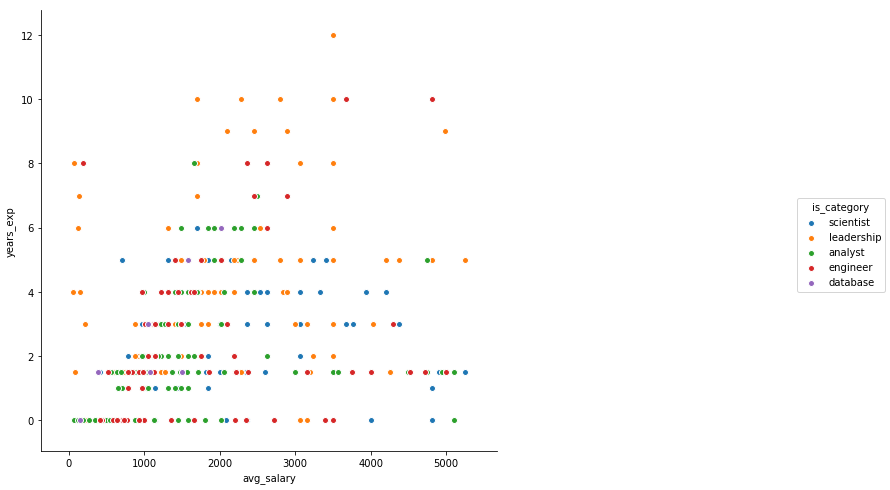

In [91]:
# plt.rcParams['figure.figsize']=(15,15)
g = sns.pairplot(data=df2[df2.avg_salary < 3*np.std(df2.avg_salary)],x_vars=['avg_salary'],y_vars=['years_exp'],hue='is_category')
g.fig.set_size_inches(16,9)

In [92]:
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,make_scorer, recall_score,precision_score,fbeta_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

C:\Anaconda\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [93]:
stop_words = pd.read_csv('./stopwords.csv',names=['stop'])
new_stop = stop_words.stop.map(lambda x: str.capitalize(x))
all_stop_set = set(stop_words.stop.append(new_stop,ignore_index=True))

#generate combinations of all_stop_words, bigrams
#generate bigram
bigram_stops=[]
for a in all_stop_set:
    for b in all_stop_set:
        bigram_stop = a+"_"+b
        bigram_stops.append(bigram_stop)
all_stop_set = all_stop_set.union(bigram_stops)

In [94]:
def read_corpus(sentdf, tokens_only=False):
    for i, line in enumerate(sentdf):
        if tokens_only:
            yield list(gensim.utils.tokenize(line))
        else:
            yield gensim.models.doc2vec.TaggedDocument(list(gensim.utils.tokenize(line)),[i])

In [95]:
df2.shape

(488, 12)

In [96]:
sentence_stream = list(read_corpus(df2.description, tokens_only=True))

In [97]:
phrases = Phrases(sentence_stream, threshold=2, min_count=2, common_terms=list(all_stop_set))
bigram = Phraser(phrases)
bg_ss = [bigram[s] for s in sentence_stream]

def filter_stream(df, stopword_set):
    sentence_stream = []
    for s in df:
        s2 = [c  for c in s if c not in stopword_set] 
        sentence_stream.append(s2)
    return sentence_stream

bg_ss = filter_stream(bg_ss, all_stop_set)

In [98]:
dictionary = corpora.Dictionary(sentence_stream)
corpus_bow = [dictionary.doc2bow(s) for s in sentence_stream]
tfidf = models.TfidfModel(corpus_bow)

In [99]:
num_topics = 100
chunksize = 400
passes = 5
model = models.LdaModel(tfidf[corpus_bow], id2word=dictionary, num_topics=num_topics)

In [100]:
topic_dists = np.zeros([len(sentence_stream),num_topics])
    
for i,item in enumerate(corpus_bow):       
    dists = model.get_document_topics(item)        
    indices = list(dict(dists).keys())        
    vals = list(dict(dists).values())        
    topic_dists[i,indices] = vals
topic_dists = pd.DataFrame(topic_dists, columns = ['topic'+str(a) for a in range(num_topics)])

In [101]:
# there are no clear single topic that explains a lot of variance 
pca = PCA(n_components=5)
pca.fit(topic_dists)
print(pca.explained_variance_ratio_)
pca_feat = pd.DataFrame(pca.components_, columns = topic_dists.columns).T
for a in pca_feat.columns:
    pos = int(re.findall(r'[0-9]+',pca_feat[a].idxmax())[0])
    print(pca_feat[a].idxmax()+ ": " + model.print_topic(pos))

[0.10076289 0.07290796 0.06103589 0.05522441 0.04728068]
topic31: 0.003*"Hadoop" + 0.003*"Spark" + 0.002*"Analytics" + 0.002*"NLP" + 0.002*"Excel" + 0.002*"development" + 0.002*"model" + 0.002*"client" + 0.002*"evaluate" + 0.002*"technologies"
topic92: 0.003*"marketing" + 0.002*"model" + 0.002*"massive" + 0.002*"You" + 0.002*"products" + 0.002*"propensity" + 0.002*"C" + 0.002*"machine" + 0.002*"data" + 0.002*"B"
topic17: 0.004*"Chennai" + 0.004*"Pentaho" + 0.004*"Regression" + 0.003*"Extraction" + 0.003*"Rdbms" + 0.003*"Sql" + 0.003*"Etl" + 0.003*"Sas" + 0.002*"Linear" + 0.002*"Qlikview"
topic47: 0.003*"Talend" + 0.002*"WWA" + 0.002*"Hadoop" + 0.002*"Race" + 0.002*"analyze" + 0.002*"Pentaho" + 0.002*"ETL" + 0.002*"systems" + 0.002*"database" + 0.002*"B"
topic94: 0.004*"Hadoop" + 0.004*"Learning" + 0.004*"Spark" + 0.003*"Regression" + 0.003*"Machine" + 0.003*"R" + 0.003*"Point" + 0.003*"Tableau" + 0.003*"Power" + 0.003*"Logistic"


In [102]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
ss = StandardScaler()
X = topic_dists
# y = ss.fit_transform(df2.salary_type)
y = df2.salary_type
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=2)

C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [103]:
def run_test(X, y, cv_val, scoring):
    gnb = GaussianNB()
    dtree = DecisionTreeClassifier()
    svm2 = svm.SVC(random_state=8)
    xg = XGBClassifier()
    lr = linear_model.LogisticRegression()
    rf = RandomForestClassifier(max_depth=3, random_state=8)
    ada = AdaBoostClassifier(n_estimators=100)
    # logreg_cv = linear_model.LogisticRegressionCV(Cs=100, cv=5, penalty='l1',scoring='accuracy',solver='liblinear',n_jobs=-1)
    print('Gaussian NB:')
    scorelist = cross_val_score(gnb, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('DecisionTree')
    scorelist = cross_val_score(dtree, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('SVM:')
    scorelist = cross_val_score(svm2, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('XGB Default:')
    scorelist = cross_val_score(xg, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('LR:')
    scorelist = cross_val_score(lr, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('Rand Forest:')
    scorelist = cross_val_score(rf, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('Adaboost:')
    scorelist = cross_val_score(ada, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))

In [104]:
run_test(X,y,5,'precision')

Gaussian NB:
[0.50847458 0.55       0.5        0.44642857 0.5       ] 0.5009806295399516
DecisionTree
[0.55813953 0.55       0.55737705 0.52       0.51785714] 0.5406747453842382
SVM:
[0.53061224 0.53061224 0.53061224 0.53061224 0.53125   ] 0.5307397959183674
XGB Default:
[0.62       0.61363636 0.62318841 0.57627119 0.51851852] 0.5903228948785324
LR:
[0.5308642  0.53932584 0.54022989 0.51898734 0.52380952] 0.5306433581733281
Rand Forest:
[0.56       0.53191489 0.55405405 0.56578947 0.48387097] 0.5391258778194443
Adaboost:
[0.61702128 0.59574468 0.53225806 0.53571429 0.50877193] 0.5579020475003569


In [105]:
# PCA transformed
# run_test(pca.transform(X),y, 5,'precision')

In [106]:
lr = linear_model.LinearRegression()
scorelist = cross_val_score(lr, X, df2.avg_salary, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
print(scorelist, np.mean(scorelist))

[-5.72622672e+32 -2.52968575e+31 -3.93906396e+06 -3.06119502e+06
 -3.26934403e+30] -1.2023777473972187e+32


In [107]:
bg_ss_corpus = []
for ind,s in enumerate(bg_ss):
    bg_ss_corpus.append(gensim.models.doc2vec.TaggedDocument(s,[ind]))

In [108]:
d2vmodel = gensim.models.doc2vec.Doc2Vec(dm=0, size=200,min_count=2, window=5,workers=cores, seed=8, negative=5)
d2vmodel.build_vocab(bg_ss_corpus)
d2vmodel.train(bg_ss_corpus, total_examples=d2vmodel.corpus_count, epochs=d2vmodel.iter)

276469

In [109]:
d2vec = pd.DataFrame([d2vmodel.infer_vector(s.words) for s in bg_ss_corpus])

In [110]:
pca = PCA(n_components=10)
pca.fit(d2vec)
print(pca.explained_variance_ratio_)
X_proj = pca.transform(d2vec)
X_rec = pca.inverse_transform(X_proj)

[9.98538470e-01 6.81740345e-05 4.92664659e-05 3.89739785e-05
 3.39871341e-05 2.86874680e-05 2.58262746e-05 2.48724563e-05
 2.19684587e-05 2.12964455e-05]


In [ ]:
run_test(d2vec, y, 5, 'precision')

In [112]:
lr = linear_model.LinearRegression()
# X_train, X_test, y_train, y_test  = train_test_split(np.reshape(df2.years_exp,(-1,1)), df2.avg_salary, train_size=0.75, random_state=8)
X_train, X_test, y_train, y_test  = train_test_split(X_proj, df2.avg_salary, train_size=0.75, random_state=8)
lr.fit(X_train, y_train)
print(lr.score(X_test,y_test))

C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.04611335069293821


In [113]:
#non-nlp
import patsy
cat_vec = pd.get_dummies(df2.is_category)
# cat_vec.reset_index(inplace=True)

In [114]:
run_test(cat_vec, y, 5, 'precision')

Gaussian NB:
[0.75675676 0.64705882 0.63076923 0.57575758 0.57746479] 0.6375614351090739
DecisionTree
[0.75675676 0.64705882 0.69090909 0.57575758 0.61538462] 0.6571733724674902
SVM:
[0.75675676 0.64705882 0.69090909 0.57575758 0.61538462] 0.6571733724674902
XGB Default:
[0.75675676 0.64705882 0.69090909 0.57575758 0.61538462] 0.6571733724674902
LR:
[0.75675676 0.64705882 0.69090909 0.57575758 0.61538462] 0.6571733724674902
Rand Forest:
[0.75675676 0.64705882 0.69090909 0.67346939 0.61538462] 0.6767157348669954
Adaboost:
[0.75675676 0.64705882 0.69090909 0.57575758 0.61538462] 0.6571733724674902


In [115]:
all_vec = pd.concat([X, d2vec, df2.years_exp,cat_vec], axis=1, ignore_index=True, join_axes=[X.index])
# all_vec = ss.fit_transform(all_vec)
Xa_train, Xa_test, ya_train, ya_test = train_test_split(all_vec, y, train_size=0.7, random_state=8)

C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [116]:
pca = PCA(n_components=10)
pca.fit(all_vec)
print(pca.explained_variance_ratio_)
all_proj = pca.transform(all_vec)
all_rec = pca.inverse_transform(all_proj)

[0.8071223  0.06967011 0.03834645 0.03318555 0.02790921 0.00270126
 0.00211527 0.00144254 0.00111519 0.00109653]


In [117]:
# Good results on SVM, XGB results. Text 
run_test(all_vec, y, 5, 'precision')

Gaussian NB:
[0.52631579 0.56862745 0.49122807 0.5        0.50877193] 0.5189886480908154
DecisionTree
[0.75       0.65116279 0.75471698 0.65517241 0.62962963] 0.6881363630504966
SVM:
[1.         1.         0.67164179 0.72727273 0.65517241] 0.8108173864221213
XGB Default:
[0.7027027  0.71794872 0.77358491 0.70175439 0.66101695] 0.7114015322858506
LR:
[0.74074074 0.82758621 0.75       0.68656716 0.609375  ] 0.7228538223632794
Rand Forest:
[0.60869565 0.58333333 0.65116279 0.60344828 0.58181818] 0.6056916467770345
Adaboost:
[0.64864865 0.68085106 0.6557377  0.63333333 0.59649123] 0.6430123957599955


In [118]:
sal_lgcv = linear_model.LogisticRegressionCV(Cs=100,penalty='l2',solver='newton-cg',multi_class='multinomial')
sal_lgcv.fit(Xa_train, ya_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [119]:
best_pred = sal_lgcv.predict(Xa_test)
print(classification_report(ya_test, best_pred,))

             precision    recall  f1-score   support

          0       0.45      0.93      0.61        58
          1       0.85      0.26      0.40        89

avg / total       0.69      0.52      0.48       147



In [120]:
xg_clf = XGBClassifier()
xg_params = {
#     'booster'=['gbtree'],
    'colsample_bytree':[0.15,0.4,0.85],
    'max_depth':[4,8,16,20],
    'subsample':[0.7,0.95],
    'min_child_weight':[1,3,9],
    'gamma':[0,0.01,0.05,0.3,0.6,1]
}
scorer = make_scorer(fbeta_score,beta=0.5)
xg_gs = GridSearchCV(xg_clf, xg_params, cv=5, scoring=scorer, n_jobs=-1)
xg_gs.fit(Xa_train,ya_train)
best_xg_clf = xg_gs.best_estimator_
print(best_xg_clf)
best_pred = best_xg_clf.predict(Xa_test)
print(classification_report(ya_test, best_pred,))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0.3, learning_rate=0.1, max_delta_step=0, max_depth=16,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.95)


C:\Anaconda\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.62      0.78      0.69        58
          1       0.83      0.70      0.76        89

avg / total       0.75      0.73      0.73       147



In [121]:
svm_clf = svm.SVC(random_state=8)
svm_params = {
    "kernel":['rbf','linear'],
    'C':[0.1,0.2,0.4,0.6,0.8,1,10],
    'gamma': np.logspace(-1,1,9)
}
scorer = make_scorer(fbeta_score,beta=0.5)
svm_gs = GridSearchCV(svm_clf, svm_params, cv=5, scoring=scorer, n_jobs=-1)
svm_gs.fit(Xa_train,ya_train)
best_clf = svm_gs.best_estimator_
print(best_clf)
best_pred = best_clf.predict(Xa_test)
print(classification_report(ya_test, best_pred,))

SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.7782794100389228,
  kernel='rbf', max_iter=-1, probability=False, random_state=8,
  shrinking=True, tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.60      0.62      0.61        58
          1       0.75      0.73      0.74        89

avg / total       0.69      0.69      0.69       147



# Question 2
Factors that distinguish job category

In [122]:
def run_multi_test(X,y,cv_val,scoring):
    gnb = GaussianNB()
    knn = KNeighborsClassifier()
    log = linear_model.LogisticRegression(solver='newton-cg',multi_class='multinomial')
    rf = RandomForestClassifier()
    
    print('Gaussian NB:')
    scorelist = cross_val_score(gnb, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('KNN')
    scorelist = cross_val_score(knn, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('LOG')
    scorelist = cross_val_score(log, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    print('Random Forest:')
    scorelist = cross_val_score(rf, X, y, cv=cv_val, scoring=scoring,n_jobs=-1)
    print(scorelist, np.mean(scorelist))
    

In [123]:
le = LabelEncoder()
ym = le.fit_transform(df2.is_category)
Xm = pd.concat([X, d2vec, df2.years_exp], axis=1)

In [124]:
run_multi_test(Xm, ym, 5, 'accuracy')

Gaussian NB:
[0.32       0.29292929 0.25510204 0.29166667 0.23157895] 0.27825538955614143
KNN
[0.26       0.34343434 0.39795918 0.46875    0.38947368] 0.3719234422636678
LOG
[0.31       0.50505051 0.36734694 0.44791667 0.46315789] 0.41869440104590483
Random Forest:
[0.29       0.34343434 0.19387755 0.34375    0.27368421] 0.28894922099621345


In [125]:
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, train_size=0.8, random_state=8)

C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [126]:
rfgs_params = {
    'n_estimators':[10,20,30,40],
    'max_features':['sqrt','log2'],
    'min_samples_leaf':[1,2],
}
rfgs = GridSearchCV(RandomForestClassifier(), rfgs_params, cv=3, n_jobs=-1)
rfgs.fit(Xm_train, ym_train)
print(rfgs.best_estimator_)
best_pred = rfgs.best_estimator_.predict(Xm_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [127]:
print(classification_report(ym_test, best_pred,target_names = le.classes_))

C:\Anaconda\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 4, does not match size of target_names, 5
  .format(len(labels), len(target_names))


             precision    recall  f1-score   support

    analyst       0.32      0.42      0.36        31
   database       0.23      0.20      0.21        15
   engineer       0.35      0.38      0.36        32
 leadership       0.30      0.15      0.20        20

avg / total       0.31      0.32      0.31        98



In [128]:
svcparams = {
    'penalty':['l2'],
    'multi_class':['ovr'],
    'C': [0.1,0.5,1.0,1.5,2.0]
}
svcgs = GridSearchCV(svm.LinearSVC(), svcparams, cv=3,n_jobs=-1)
svcgs.fit(Xm_train, ym_train)
print(svcgs.best_estimator_)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [129]:
best_pred = rfgs.best_estimator_.predict(Xm_test)
print(classification_report(ym_test, best_pred,target_names = le.classes_))

C:\Anaconda\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 4, does not match size of target_names, 5
  .format(len(labels), len(target_names))


             precision    recall  f1-score   support

    analyst       0.32      0.42      0.36        31
   database       0.23      0.20      0.21        15
   engineer       0.35      0.38      0.36        32
 leadership       0.30      0.15      0.20        20

avg / total       0.31      0.32      0.31        98



# lets view the question in another way. 
</h1>Let the labels be is_leadership, and is_not_leadership </h1>
as we do not have enough data to classify them correctly. 

In [130]:
def label_lead(x):
    if x=='leadership':
        return 0
    else:
        return 1
lead_labels = df2.is_category.apply(label_lead)

In [132]:
print(pd.Series(lead_labels).value_counts())
print(df2.is_category.value_counts())

1    342
0    146
Name: is_category, dtype: int64
analyst       148
leadership    146
scientist      94
engineer       93
database        7
Name: is_category, dtype: int64


In [138]:
run_test(Xm, lead_labels, 5, 'f1')

Gaussian NB:
[0.65079365 0.56410256 0.42592593 0.45714286 0.62068966] 0.5437309306274825
DecisionTree
[0.76712329 0.79166667 0.66666667 0.74452555 0.67741935] 0.7294803046577064
SVM:
[0.82142857 0.82634731 0.82424242 0.82424242 0.82424242] 0.8241006299090131
XGB Default:
[0.78709677 0.82278481 0.76712329 0.82993197 0.75524476] 0.7924363200050468
LR:
[0.82142857 0.82424242 0.84415584 0.81081081 0.82666667] 0.8254608634608633
Rand Forest:
[0.77922078 0.82208589 0.79746835 0.82716049 0.82802548] 0.8107921989511757
Adaboost:
[0.73825503 0.79194631 0.6870229  0.82269504 0.75      ] 0.7579838557012462


In [135]:
all_jobs[all_jobs.higher_sgd < 500]

,job_title,description,required_skills,job_category,years_exp,lower_sgd,higher_sgd
37,Data Analyst,Job Description:\nWe are looking for a Data An...,Market Research Data Analysis Data Management,Community Management,0.0,98,196.000
39,Data Analyst,Responsibilities:\nDoing Data Selection & Prep...,Data Analysis Databases Big Data,Data & Analytics,0.0,343,490.000
43,Data Analyst,Pricebook - Bandingkan Harga Terbaik di Seluru...,What is it like working at PT. Pricebook Digit...,Data & Analytics,0.0,333.2,392.000
46,Data Analyst Intern,Want to work in a startup environment that fil...,Data Analysis Data Science Information Technol...,Data & Analytics,0.0,147,196.000
47,Data Analyst Intern,Want to work in a startup environment that fil...,Data Analysis Data Science Information Technol...,Data & Analytics,0.0,147,196.000
51,Data Analyst Internship,Pricebook - Bandingkan Harga Terbaik di Seluru...,Databases Data Management Microsoft Excel Data...,Data & Analytics,0.0,49,98.000
58,Data Analyst,"At ITG, our team of Analysts are the lifeblood...",Data Analysis Data Entry,Data & Analytics,0.0,315,378.000
59,Data Analyst Intern,Want to work in a startup environment that fil...,Data Analysis Data Science Algorithms,Data & Analytics,0.0,147,196.000
86,Business Analyst,We are part of a fast growing startup of over ...,Marketing Communications Business Development ...,Data & Analytics,0.0,294,392.000
88,Expansion Analyst,Responsibilities Working with the expansion t...,Business Analysis Financial Analysis Microsoft...,"Finance, Legal & Accounting",0.0,343,490.000


In [136]:
Xms_train, Xms_test, yms_train, yms_test = train_test_split(Xm, lead_labels, train_size=0.7, random_state=8)


C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
svm_clf = svm.SVC(random_state=8)
svm_params = {
    "kernel":['rbf','linear'],
    'C':[0.1,0.2,0.4,0.6,0.8,1,10],
    'gamma': np.logspace(-1,1,9)
}
scorer = make_scorer(fbeta_score,beta=0.5)
svm_gs = GridSearchCV(svm_clf, svm_params, cv=5, scoring=scorer, n_jobs=-1)
svm_gs.fit(Xms_train,yms_train)
best_clf = svm_gs.best_estimator_
print(best_clf)
best_pred = best_clf.predict(Xms_test)
print(classification_report(yms_test, best_pred,))

Leadership is probably a good class to predict as there are words used specifically for leadership roles, and there is a clear years_exp and salary clustering. Expected Xgboost to do better due to slight clustering effects but svm does ok(as expected for NLP tasks)